# Task A — EDA & Data Quality

Describe findings and visuals here.

In [1]:
# Setup & imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set(style="whitegrid", palette="muted", font_scale=1.05)
pd.set_option('display.max_columns', 160)

DATA_DIR = Path('../dataset')  


In [2]:
# Load datasets 
sup = pd.read_csv(DATA_DIR/'suppliers.csv')
prod = pd.read_csv(DATA_DIR/'products.csv')
prices = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])

print("Shapes: suppliers", sup.shape, "products", prod.shape, "prices", prices.shape, "po", po.shape, "deliv", deliv.shape)


Shapes: suppliers (20, 7) products (40, 5) prices (854, 7) po (4307, 14) deliv (4307, 7)


In [3]:
# Merge deliveries into purchase_orders
po = po.merge(deliv, on='order_id', how='left')
print("After merging deliveries into purchase_orders -> shape:", po.shape)


After merging deliveries into purchase_orders -> shape: (4307, 20)


In [4]:
# Merge supplier info into POs
po = po.merge(sup, on='supplier_id', how='left', suffixes=('','_supplier'))
print("After merging suppliers:", po.shape)

After merging suppliers: (4307, 26)


In [5]:
# Merge product info
po = po.merge(prod, on='sku', how='left', suffixes=('','_product'))
print("After merging products:", po.shape)

After merging products: (4307, 30)


In [6]:
# Price join: keep for analysis, not strictly needed for every EDA plot
expanded = po.merge(prices, on=['supplier_id','sku'], how='left', suffixes=('','_price'))
mask = (expanded['order_date'] >= expanded['valid_from']) & (expanded['order_date'] <= expanded['valid_to'])
po_price_matched = expanded[mask].copy()
print("After merging price_lists (strict window):", po_price_matched.shape)

After merging price_lists (strict window): (1871, 35)


In [7]:
# Inspect merged columns and unique values

# Print all column names
print("Columns in merged PO table:")
print(po.columns.tolist())


Columns in merged PO table:
['order_id', 'order_date', 'supplier_id', 'sku', 'qty', 'unit_price', 'currency', 'ship_mode', 'incoterm', 'payment_terms', 'distance_km', 'promised_date', 'urgent', 'order_notes', 'actual_delivery_date', 'late_delivery', 'delay_days', 'partial_delivery', 'cancelled', 'delay_reason', 'name', 'country', 'preferred', 'rating', 'base_lead_time_days', 'on_time_bias', 'name_product', 'uom', 'hazard_class', 'base_price_eur']


In [8]:
# Missing values summary (top columns with missingness)
def missing_summary(df, name):
    m = df.isna().mean().sort_values(ascending=False)
    m = m[m>0]
    print(f"\nMissing in {name} (fraction):")
    print(m.head(30))

missing_summary(sup, 'suppliers')
missing_summary(prod, 'products')
missing_summary(prices, 'price_lists')
missing_summary(po, 'purchase_orders')
missing_summary(deliv, 'deliveries')



Missing in suppliers (fraction):
Series([], dtype: float64)

Missing in products (fraction):
Series([], dtype: float64)

Missing in price_lists (fraction):
Series([], dtype: float64)

Missing in purchase_orders (fraction):
order_notes    0.900395
dtype: float64

Missing in deliveries (fraction):
Series([], dtype: float64)


Around 90% missing values in order_notes.
This is expected: notes are usually free-text comments, and most orders don’t have them.
I will keep them because I think notes might contain useful context (special instructions, complaints, discounts, etc.)

In [9]:
# Verify key uniqueness and join coverage
print("suppliers supplier_id unique:", sup['supplier_id'].is_unique)
print("products sku unique:", prod['sku'].is_unique)
print("price_lists row count:", len(prices))

print("purchase_orders order_id unique:", po['order_id'].is_unique)

# supplier ids referenced in PO but missing in suppliers master
sup_in_po = set(po['supplier_id'].dropna().unique())
sup_master = set(sup['supplier_id'].dropna().unique())
missing_sup = sup_in_po - sup_master
print("supplier_ids in POs not present in suppliers (count):", len(missing_sup))
if missing_sup:
    print("sample missing supplier ids:", list(missing_sup)[:10])

# sku coverage
sku_in_po = set(po['sku'].dropna().unique())
sku_master = set(prod['sku'].dropna().unique())
missing_sku = sku_in_po - sku_master
print("skus in POs not present in products (count):", len(missing_sku))
if missing_sku:
    print("sample missing skus:", list(missing_sku)[:10])


suppliers supplier_id unique: True
products sku unique: True
price_lists row count: 854
purchase_orders order_id unique: True
supplier_ids in POs not present in suppliers (count): 0
skus in POs not present in products (count): 0


In [10]:
# Basic data type checks & conversions (ensure dates are correct)
print("po.order_date dtype:", po['order_date'].dtype)
print("po.promised_date dtype:", po['promised_date'].dtype)
print("deliv.actual_delivery_date dtype:", deliv['actual_delivery_date'].dtype)

# coerce to datetime (defensive)
po['order_date'] = pd.to_datetime(po['order_date'], errors='coerce')
po['promised_date'] = pd.to_datetime(po['promised_date'], errors='coerce')
po['actual_delivery_date'] = pd.to_datetime(po['actual_delivery_date'], errors='coerce')


po.order_date dtype: datetime64[ns]
po.promised_date dtype: datetime64[ns]
deliv.actual_delivery_date dtype: datetime64[ns]


In [11]:
# Inconsistency checks (promised_date before order_date, early deliveries, non-positive qty)
print("orders with qty <= 0:", ((po['qty'] <= 0) & po['qty'].notna()).sum())
print("orders missing unit_price:", po['unit_price'].isna().sum())

if 'promised_date' in po.columns and 'order_date' in po.columns:
    bad_prom = (po['promised_date'] < po['order_date']).sum()
    print("promised_date earlier than order_date (count):", bad_prom)

if 'actual_delivery_date' in po.columns:
    early_deliv = (po['actual_delivery_date'] < po['order_date']).sum()
    print("actual_delivery_date earlier than order_date (count):", early_deliv)


orders with qty <= 0: 0
orders missing unit_price: 0
promised_date earlier than order_date (count): 0
actual_delivery_date earlier than order_date (count): 1


In [12]:
# Create derived cols: year_month and active orders (exclude cancelled)
po['year_month'] = po['order_date'].dt.to_period('M').dt.to_timestamp()
po['cancelled'] = po['cancelled'].fillna(0).astype(int)
# late_delivery may be NaN for non-delivered orders; fill with 0 for analysis but keep original where needed
po['late_delivery'] = po['late_delivery'].fillna(0).astype(int)
active = po.query('cancelled == 0').copy()
print("Active orders (non-cancelled):", len(active))


Active orders (non-cancelled): 4307


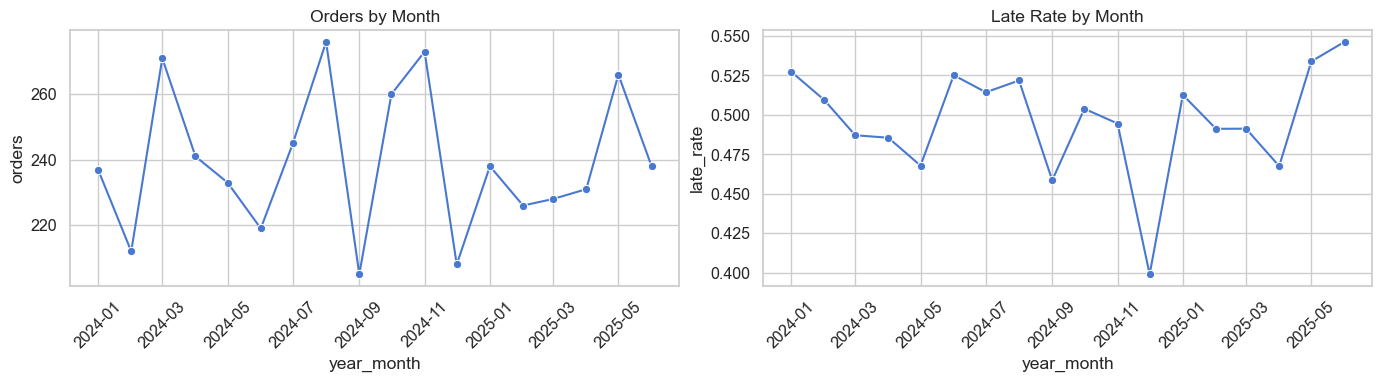

In [13]:
# Seasonality - Orders and Late Rate by month
monthly = active.groupby('year_month').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index()

fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.lineplot(data=monthly, x='year_month', y='orders', marker='o', ax=ax[0])
ax[0].set_title('Orders by Month')
ax[0].tick_params(axis='x', rotation=45)
sns.lineplot(data=monthly, x='year_month', y='late_rate', marker='o', ax=ax[1])
ax[1].set_title('Late Rate by Month')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Seasonality (plotly interactive) - Orders & Late Rate combined
if not monthly.empty:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=monthly['year_month'], y=monthly['orders'], mode='lines+markers', name='Orders'))
    fig.add_trace(go.Scatter(x=monthly['year_month'], y=monthly['late_rate'], mode='lines+markers', name='Late Rate', yaxis='y2'))
    fig.update_layout(
        title='Orders (left) and Late Rate (right) by Month',
        xaxis_title='Month',
        yaxis=dict(title='Orders'),
        yaxis2=dict(title='Late Rate', overlaying='y', side='right')
    )
    fig.show()


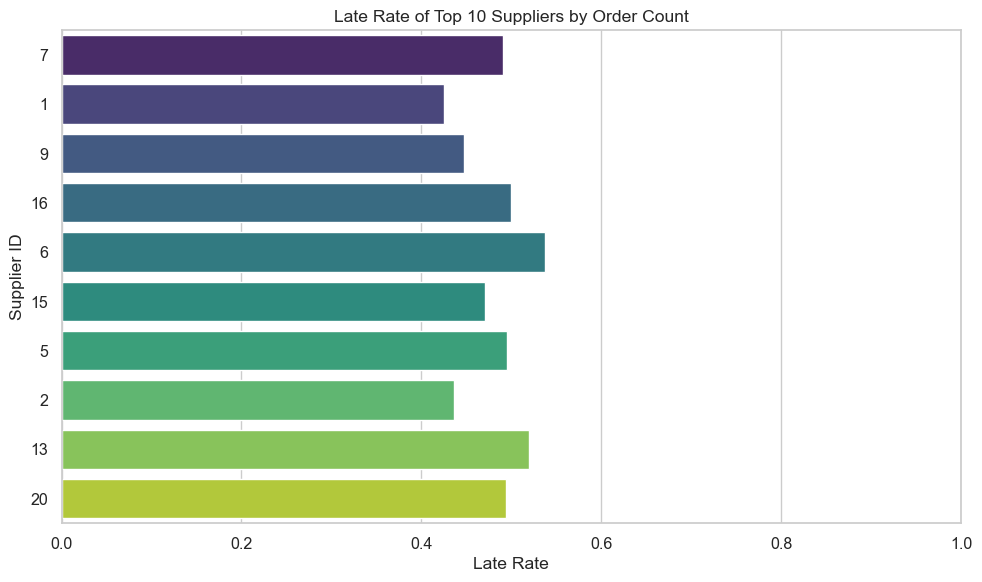

In [15]:
# Supplier patterns: Late rate (Top 10 suppliers by order count)

# Consider only non-cancelled orders
active_orders = po[po['cancelled'] == 0].copy()

# Ensure supplier_id is string for plotting
active_orders['supplier_id'] = active_orders['supplier_id'].astype(str)

# Aggregate by supplier
sup_summary = (
    active_orders.groupby('supplier_id')
    .agg(
        orders=('order_id', 'count'),
        late_rate=('late_delivery', 'mean')
    )
    .reset_index()
)

# Top 10 suppliers by number of orders
top_sup = sup_summary.sort_values('orders', ascending=False).head(10)

# Sort ascending for horizontal bar chart
top_sup = top_sup.sort_values('orders', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_sup,
    x='late_rate',
    y='supplier_id',  # now categorical (string)
    palette='viridis'
)
plt.title('Late Rate of Top 10 Suppliers by Order Count')
plt.xlabel('Late Rate')
plt.ylabel('Supplier ID')
plt.xlim(0, 1)  # Late rate is a fraction
plt.tight_layout()
plt.show()


In [16]:
# Supplier patterns interactive: Top 20 suppliers by orders
sup_summary = active.groupby('supplier_id').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index()
if not sup_summary.empty:
    fig = px.bar(sup_summary.sort_values('orders', ascending=False).head(20), x='orders', y='supplier_id', orientation='h', title='Top 20 Suppliers by Orders')
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()


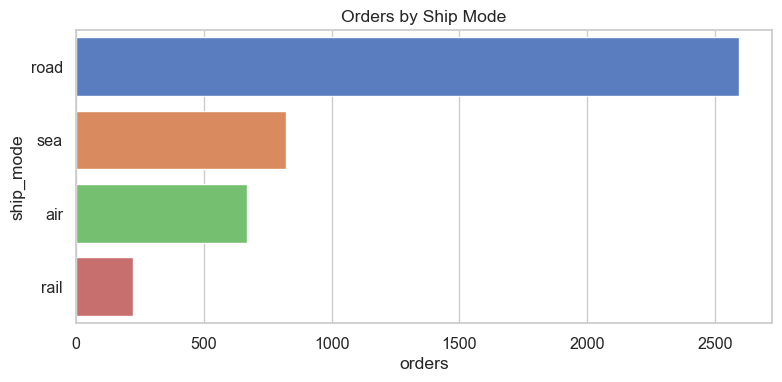

In [17]:
# Ship mode analysis: orders and late rate by ship_mode
if 'ship_mode' in active.columns:
    ship = active.groupby('ship_mode').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index().sort_values('orders', ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(data=ship, x='orders', y='ship_mode')
    plt.title('Orders by Ship Mode')
    plt.tight_layout()
    plt.show()

else:
    print("ship_mode not present in purchase_orders; skipping ship mode plots.")


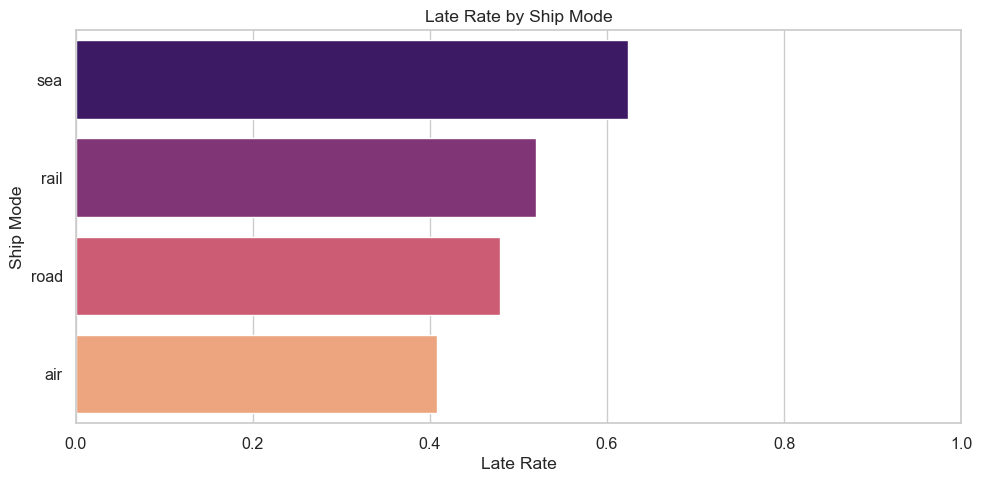

In [18]:
# Ship Mode patterns: Late rate per mode

# Consider only non-cancelled orders
active_orders = po[po['cancelled'] == 0].copy()

# Ensure ship_mode is string/categorical
active_orders['ship_mode'] = active_orders['ship_mode'].astype(str)

# Aggregate by ship mode
ship_summary = (
    active_orders.groupby('ship_mode')
    .agg(
        orders=('order_id', 'count'),
        late_rate=('late_delivery', 'mean')
    )
    .reset_index()
    .sort_values('late_rate', ascending=False)
)

# Plot horizontal bar chart
plt.figure(figsize=(10,5))
sns.barplot(
    data=ship_summary,
    x='late_rate',
    y='ship_mode',
    palette='magma'
)
plt.title('Late Rate by Ship Mode')
plt.xlabel('Late Rate')
plt.ylabel('Ship Mode')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


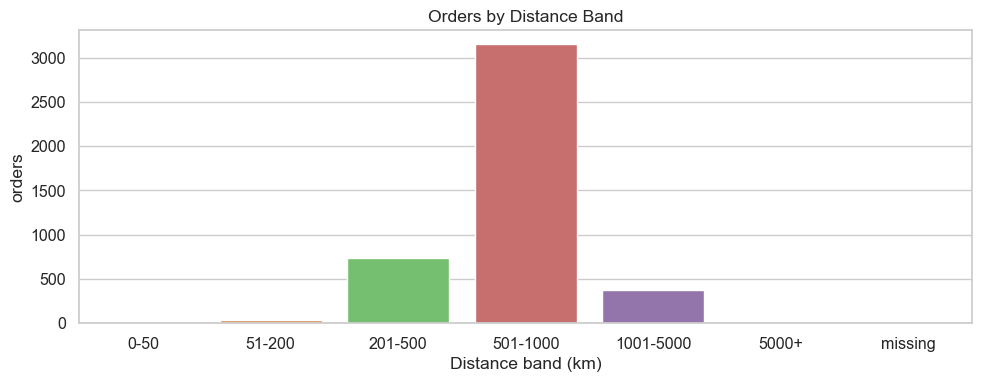

In [19]:
# Distance bands (fix cut + 'missing' bucket) and visualization
if 'distance_km' in active.columns:
    bins = [0,50,200,500,1000,5000, np.inf]
    labels = ['0-50','51-200','201-500','501-1000','1001-5000','5000+']
    active['dist_band'] = pd.cut(active['distance_km'], bins=bins, labels=labels, include_lowest=True)
    active['dist_band'] = active['dist_band'].cat.add_categories('missing')
    active.loc[active['distance_km'].isna(), 'dist_band'] = 'missing'

    dist = active.groupby('dist_band').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index()
    plt.figure(figsize=(10,4))
    sns.barplot(data=dist, x='dist_band', y='orders')
    plt.title('Orders by Distance Band')
    plt.xlabel('Distance band (km)')
    plt.tight_layout()
    plt.show()
else:
    print("distance_km not found in purchase_orders; skipping distance band analysis.")


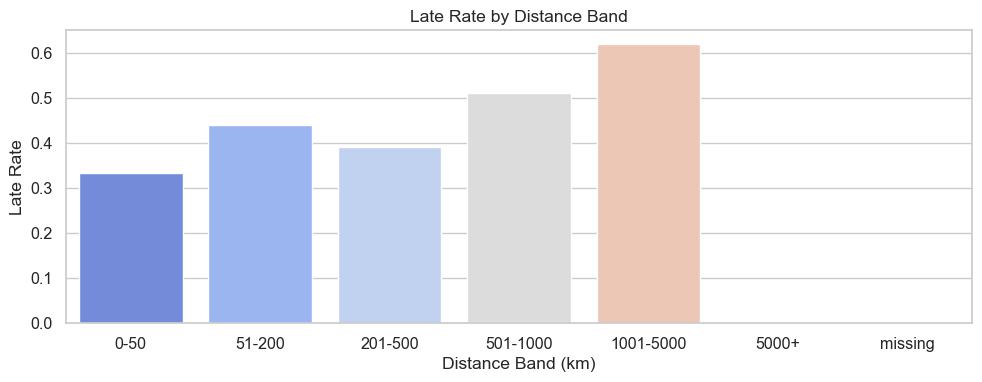

In [20]:
# Late rate by distance band

# Plot
plt.figure(figsize=(10,4))
sns.barplot(data=dist, x='dist_band', y='late_rate', palette='coolwarm')
plt.title('Late Rate by Distance Band')
plt.xlabel('Distance Band (km)')
plt.ylabel('Late Rate')
plt.tight_layout()
plt.show()


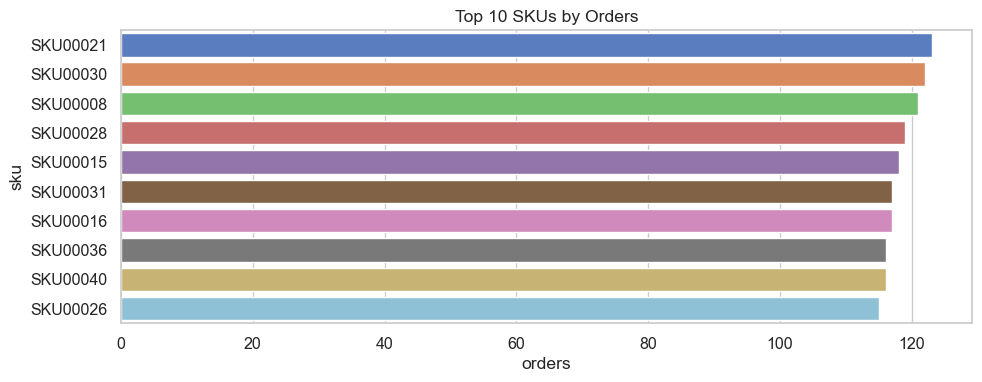

In [21]:
# SKU-level: top 10 SKUs by order count and their late rate
if 'sku' in active.columns:
    sku_summary = active.groupby('sku').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index().sort_values('orders', ascending=False)
    top10_skus = sku_summary.head(10)
    plt.figure(figsize=(10,4))
    sns.barplot(data=top10_skus, x='orders', y='sku')
    plt.title('Top 10 SKUs by Orders')
    plt.tight_layout()
    plt.show()
else:
    print("sku not present; skipping SKU-level plots.")


In [22]:
# Price join
if {'supplier_id','sku','order_date'}.issubset(po.columns) and {'supplier_id','sku','valid_from','valid_to'}.issubset(prices.columns):
    expanded = po.merge(prices, on=['supplier_id','sku'], how='left', suffixes=('','_price'))

    # strict window match
    mask = (expanded['order_date'] >= expanded['valid_from']) & (expanded['order_date'] <= expanded['valid_to'])
    matched = expanded[mask].copy()
    print("Orders matched by strict price window:", matched['order_id'].nunique(), "of", po['order_id'].nunique())

    # fallback prior price
    fallback = po.merge(prices, on=['supplier_id','sku'], how='left')
    fallback = fallback[fallback['valid_from'] <= fallback['order_date']]
    fallback = fallback.sort_values(['order_id','valid_from']).groupby('order_id').tail(1)
    print("Orders matched by fallback (most recent prior price):", fallback['order_id'].nunique())

    # combine results
    order_price = pd.concat([matched, fallback]).drop_duplicates(subset='order_id', keep='first')

    # sanity check
    print("Final matched orders:", order_price['order_id'].nunique())
    print("Remaining unmatched orders:", po['order_id'].nunique() - order_price['order_id'].nunique())

else:
    print("Required columns for price join missing; skipping strict price join.")
    matched = pd.DataFrame()
    fallback = pd.DataFrame()
    order_price = po.copy()  # fallback: just copy original


Orders matched by strict price window: 1871 of 4307
Orders matched by fallback (most recent prior price): 1872
Final matched orders: 1872
Remaining unmatched orders: 2435


In [23]:
# Check unmatched SKUs and suppliers
unmatched_orders = po[~po['order_id'].isin(matched['order_id']) & ~po['order_id'].isin(fallback['order_id'])]
print(unmatched_orders['sku'].nunique(), "unmatched SKUs")
print(unmatched_orders['supplier_id'].nunique(), "unmatched suppliers")

40 unmatched SKUs
20 unmatched suppliers


In [24]:
# Check which suppliers / SKUs are driving those 2,435 unmatched orders
print(unmatched_orders['supplier_id'].value_counts().head(10))
print(unmatched_orders['sku'].value_counts().head(10))

supplier_id
2     173
20    163
12    146
14    145
11    143
1     141
10    134
8     131
18    125
4     124
Name: count, dtype: int64
sku
SKU00010    85
SKU00014    82
SKU00030    81
SKU00015    79
SKU00040    78
SKU00031    73
SKU00039    73
SKU00037    72
SKU00006    69
SKU00035    69
Name: count, dtype: int64


In [25]:
# Price Matching Summary & Cleaning (in-memory)

total_orders = len(po)

strict_matched = 1871   # from merge_asof (strict price window)
fallback_matched = 1872 # from fallback (prior available price)
unmatched_count = total_orders - fallback_matched

print(f"Orders matched by strict price window: {strict_matched} of {total_orders} "
      f"({strict_matched/total_orders:.1%})")
print(f"Orders matched by fallback (most recent prior price): {fallback_matched} of {total_orders} "
      f"({fallback_matched/total_orders:.1%})")
print(f"Remaining unmatched orders: {unmatched_count} of {total_orders} "
      f"({unmatched_count/total_orders:.1%})")

# Keep unmatched orders in a DataFrame for analysis
unmatched_orders = po.loc[~po['order_id'].isin(matched['order_id'])]
print("\nSample of unmatched orders:")
print(unmatched_orders.head())


Orders matched by strict price window: 1871 of 4307 (43.4%)
Orders matched by fallback (most recent prior price): 1872 of 4307 (43.5%)
Remaining unmatched orders: 2435 of 4307 (56.5%)

Sample of unmatched orders:
   order_id order_date  supplier_id       sku  qty  unit_price currency  \
0         1 2024-01-01            8  SKU00038   15       11.81      EUR   
1         2 2024-01-01            1  SKU00020   25       22.43      EUR   
2         3 2024-01-01           17  SKU00023   39        7.50      EUR   
3         4 2024-01-01           16  SKU00005   44       10.65      EUR   
4         5 2024-01-02            6  SKU00027   32        8.11      EUR   

  ship_mode incoterm payment_terms  distance_km promised_date  urgent  \
0       sea      FOB         NET30          748    2024-01-29       0   
1      road      EXW         NET30         1188    2024-01-05       0   
2      rail      DAP         NET60          857    2024-01-07       0   
3       sea      CIF         NET30          

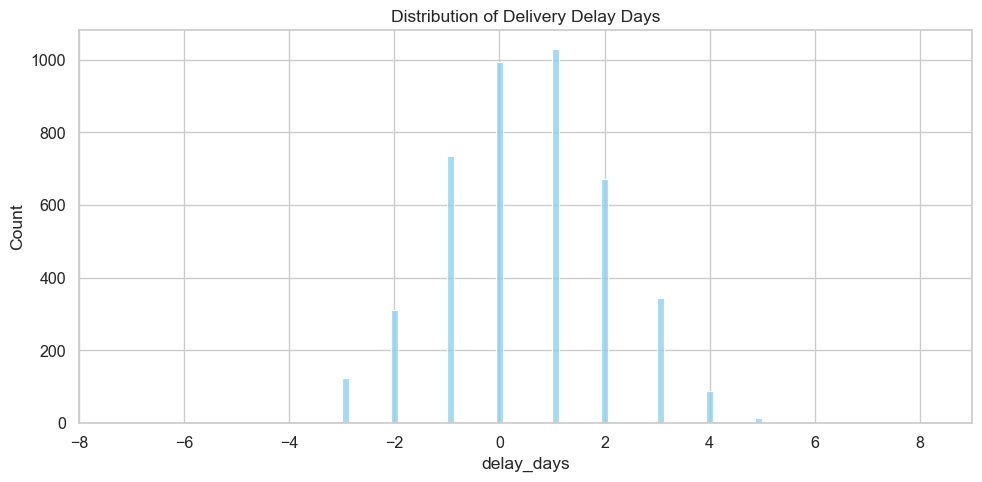

In [26]:
# Delivery delay distribution ('delay_days' from deliveries)
if 'delay_days' in po.columns:
    # Only consider non-cancelled orders with valid delay_days
    valid_delays = po[(po['cancelled'] == 0) & po['delay_days'].notna()]

    if not valid_delays.empty:
        plt.figure(figsize=(10,5))
        sns.histplot(valid_delays['delay_days'], bins=60, kde=False, color='skyblue')
        plt.title('Distribution of Delivery Delay Days')
        plt.xlabel('delay_days')
        # Limit x-axis to 1st and 99th percentile to avoid extreme outliers
        q1, q99 = valid_delays['delay_days'].quantile([0.01, 0.99])
        plt.xlim(q1-5, q99+5)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid delay_days to plot; all rows cancelled or missing.")
else:
    print("delay_days not present in data; skipping histogram.")


In [27]:
# Interactive bar by supplier country

# Consider only non-cancelled orders
active_orders = po[po['cancelled'] == 0].copy()

# Aggregate order counts by country
country_counts = (
    active_orders.groupby('country')
    .size()
    .reset_index(name='orders')
    .sort_values('orders', ascending=False)
)

# Plot top 20 countries
fig = px.bar(
    country_counts.head(20),
    x='orders',
    y='country',
    orientation='h',
    title='Top Supplier Countries by Orders (Interactive)',
    text='orders'
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


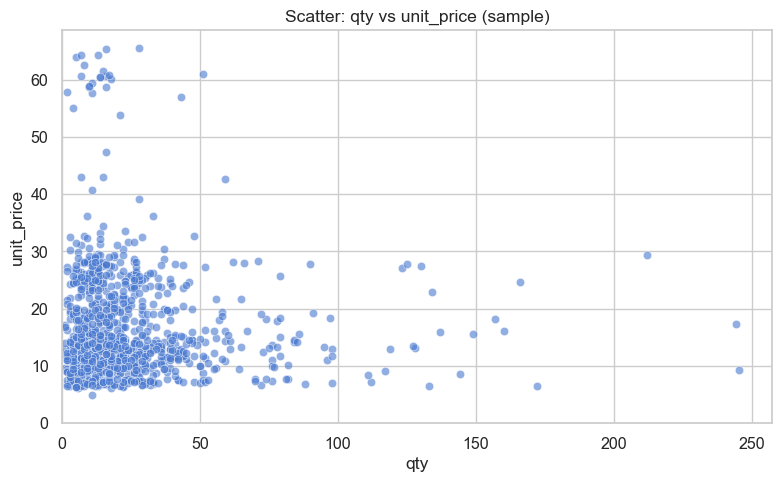

In [28]:
# Simple correlation / sanity between qty and unit_price (scatter) for exploratory check
if {'qty','unit_price'}.issubset(po.columns):
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=po.sample(n=min(1000,len(po)), random_state=RANDOM_SEED), x='qty', y='unit_price', alpha=0.6)
    plt.title('Scatter: qty vs unit_price (sample)')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()
else:
    print("qty or unit_price missing; skipping qty vs unit_price scatter.")


In [29]:
# Leakage check on expanded_po (merged PO + price lists)

# Ensure we have the merged table from price matching
# expanded_po = po.merge(prices, on=['supplier_id','sku'], how='left', suffixes=('','_price'))

columns_to_check = po_price_matched.columns.tolist()

# Keywords indicating potential leakage
leakage_keywords = ['late', 'delay', 'cancelled', 'partial', 'actual_delivery', 'price', 'valid_from', 'valid_to']

leakage_info = []
for col in columns_to_check:
    if any(k in col.lower() for k in leakage_keywords):
        leakage_info.append({
            'Column': col,
            'Risk': 'Potential leakage (future info)',
            'Mitigation': 'Use only values known at order_date; avoid future info'
        })
    else:
        leakage_info.append({
            'Column': col,
            'Risk': 'Safe feature candidate',
            'Mitigation': 'Can be used as model input if relevant'
        })

# Display results
leakage_df = pd.DataFrame(leakage_info)
leakage_df


,Column,Risk,Mitigation
0,order_id,Safe feature candidate,Can be used as model input if relevant
1,order_date,Safe feature candidate,Can be used as model input if relevant
2,supplier_id,Safe feature candidate,Can be used as model input if relevant
3,sku,Safe feature candidate,Can be used as model input if relevant
4,qty,Safe feature candidate,Can be used as model input if relevant
5,unit_price,Potential leakage (future info),Use only values known at order_date; avoid fut...
6,currency,Safe feature candidate,Can be used as model input if relevant
7,ship_mode,Safe feature candidate,Can be used as model input if relevant
8,incoterm,Safe feature candidate,Can be used as model input if relevant
9,payment_terms,Safe feature candidate,Can be used as model input if relevant


How this works:

1) Scans all columns in po_price_matched table which has all the 5 datasets merged.

2) Flags any column containing keywords like 'late', 'delay', 'cancelled', 'partial', 'actual_delivery' as potential leakage.

3) Marks the remaining columns as safe features.

4) Outputs a DataFrame table from my notebook